# Example Stock Linear Embedding

## Algorithm

### Data Loading and Feature Creation:
- We download one year of closing prices for 20 stocks and compute daily percentage returns. Each stock is represented as a 252-dimensional vector.

### Embedding Stage:
- A linear layer reduces the 252-dimensional input into a 32-dimensional embedding. This stage transforms raw features into a more compact latent representation.

### Attention Stage:
- The nn.MultiheadAttention layer takes the embedded vectors and computes context-aware representations by assigning attention weights between each pair of stocks. These weights indicate how much one stock’s features influence another’s representation.

###  Visualization:
- We use PCA to reduce each representation (raw, embedded, and post-attention) to 2D so we can visualize how the stocks “move” in feature space across the stages. We also plot a heatmap of the attention weights to see inter-stock influence.

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  20 of 20 completed


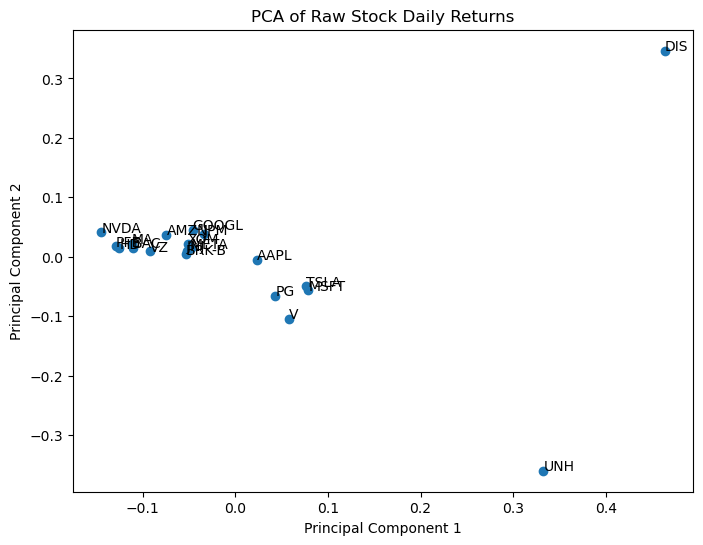

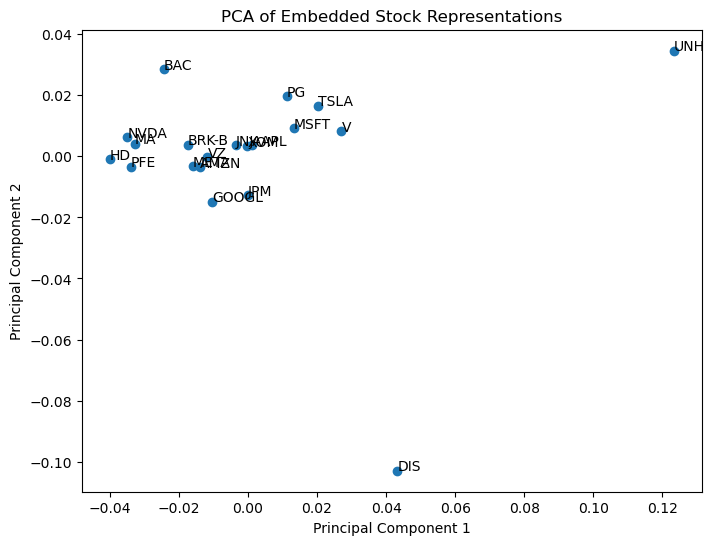

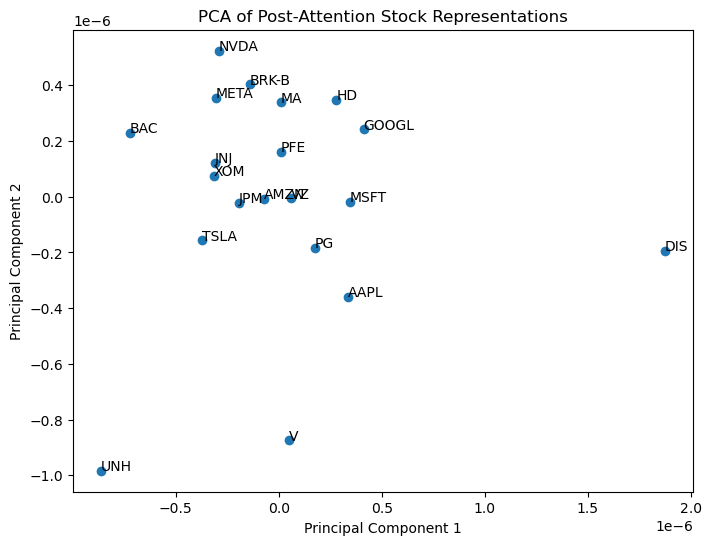

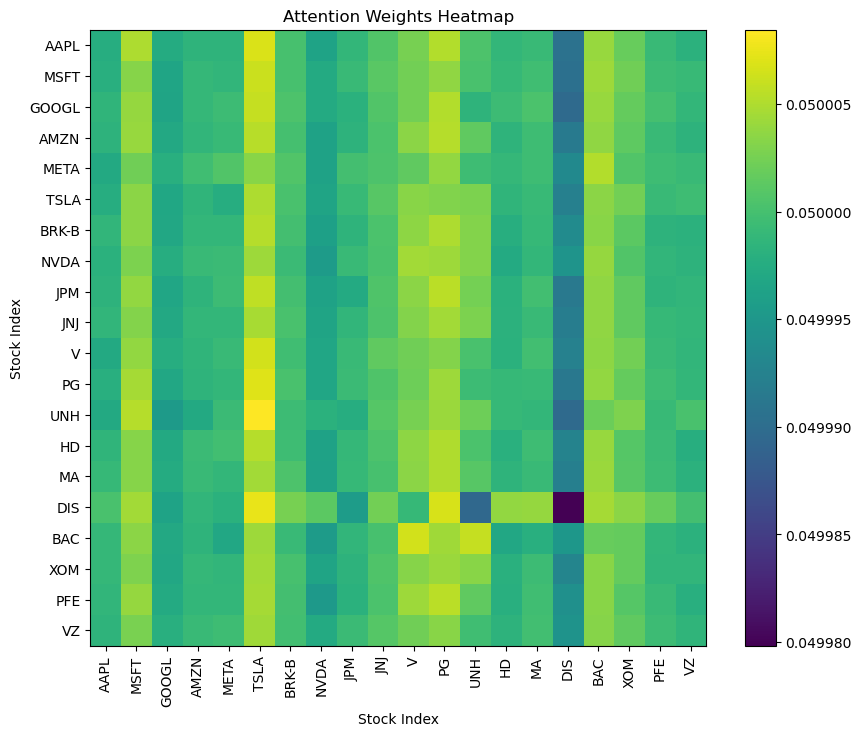

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. Data Download and Preprocessing
# Define 20 tickers (feel free to change these to your desired symbols)
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'BRK-B', 
           'NVDA', 'JPM', 'JNJ', 'V', 'PG', 'UNH', 'HD', 'MA', 
           'DIS', 'BAC', 'XOM', 'PFE', 'VZ']

# Download one year of daily close prices using yfinance
data = yf.download(tickers, period='1y')['Close']

# Forward-fill and drop any missing values
data = data.ffill().dropna()

# Compute daily returns
returns = data.pct_change().dropna()

# For consistency, use the most recent 252 trading days (roughly one year)
returns = returns.tail(252)

# Our features will be each stock's daily returns.
# The DataFrame shape is (252 days, 20 stocks); we want (20, 252) so each stock is a sample.
stock_features = returns.T.values  # shape: (20, 252)

# Convert to a PyTorch tensor (dtype float)
x = torch.tensor(stock_features, dtype=torch.float)

# 2. Define the PyTorch Model with an Embedding and an Attention Layer
class StockModel(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads):
        super(StockModel, self).__init__()
        # The embedding layer projects the 252-d input into a lower-dimensional space.
        self.embedding = nn.Linear(input_dim, embed_dim)
        # Use MultiheadAttention for self-attention. It expects input of shape (L, N, E).
        self.attention = nn.MultiheadAttention(embed_dim, num_heads)
        
    def forward(self, x):
        # x: (num_stocks, input_dim)
        embedded = self.embedding(x)  # -> (num_stocks, embed_dim)
        
        # Prepare for attention: add a batch dimension.
        # New shape becomes (num_stocks, batch_size=1, embed_dim)
        x_emb = embedded.unsqueeze(1)
        
        # Apply self-attention: the same tensor is used for query, key, and value.
        # The attention layer returns:
        # - attn_output: shape (num_stocks, 1, embed_dim)
        # - attn_weights: shape (batch_size, num_stocks, num_stocks)
        attn_output, attn_weights = self.attention(x_emb, x_emb, x_emb)
        
        # Remove the batch dimension from the output
        attn_output = attn_output.squeeze(1)  # -> (num_stocks, embed_dim)
        return embedded, attn_output, attn_weights

# Set dimensions
input_dim = x.shape[1]    # 252 (number of daily returns)
embed_dim = 32            # Chosen embedding size
num_heads = 4             # Number of attention heads

# Instantiate the model
model = StockModel(input_dim, embed_dim, num_heads)

# 3. Forward Pass Through the Model
embedded, attn_output, attn_weights = model(x)

# 4. Visualize the Representations Using PCA
def plot_pca(data, title, labels):
    # Convert data to numpy array if it is a torch tensor
    if torch.is_tensor(data):
        data = data.detach().numpy()
    pca = PCA(n_components=2)
    data_reduced = pca.fit_transform(data)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(data_reduced[:, 0], data_reduced[:, 1])
    for i, txt in enumerate(labels):
        plt.annotate(txt, (data_reduced[i, 0], data_reduced[i, 1]))
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

# Plot the PCA for raw daily returns (each stock's 252-d vector)
plot_pca(x, "PCA of Raw Stock Daily Returns", tickers)

# Plot the PCA for the embedded representations (after the Linear layer)
plot_pca(embedded, "PCA of Embedded Stock Representations", tickers)

# Plot the PCA for the output of the attention layer
plot_pca(attn_output, "PCA of Post-Attention Stock Representations", tickers)

# 5. Visualize the Attention Weights as a Heatmap
plt.figure(figsize=(10, 8))
# Remove the batch dimension from attention weights: (1, 20, 20) -> (20, 20)
attn_weights_np = attn_weights.squeeze(0).detach().numpy()
plt.imshow(attn_weights_np, cmap='viridis')
plt.colorbar()
plt.title("Attention Weights Heatmap")
plt.xlabel("Stock Index")
plt.ylabel("Stock Index")
plt.xticks(ticks=np.arange(len(tickers)), labels=tickers, rotation=90)
plt.yticks(ticks=np.arange(len(tickers)), labels=tickers)
plt.show()
